In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_hdf("/srv/beegfs/scratch/groups/rodem/LHCO/event_anomalydetection_v2.h5")

In [3]:
a = df.to_numpy()
a_bkg = a[a[:, 2100]==0, :2100]
a_sig = a[a[:, 2100]==1, :2100]

In [4]:
non_0 = np.sum(a_bkg!=0, axis=1)/3

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 2.2000e+01,
        1.7100e+02, 6.6100e+02, 1.7260e+03, 3.5360e+03, 5.9120e+03,
        8.8980e+03, 1.2084e+04, 1.5558e+04, 1.9423e+04, 2.3645e+04,
        2.6961e+04, 3.0956e+04, 3.4303e+04, 3.7986e+04, 4.0249e+04,
        4.2713e+04, 4.3992e+04, 4.5200e+04, 4.5696e+04, 4.5650e+04,
        4.4933e+04, 4.3704e+04, 4.2632e+04, 3.9917e+04, 3.8203e+04,
        3.5288e+04, 3.3121e+04, 3.0376e+04, 2.7741e+04, 2.4835e+04,
        2.1908e+04, 1.9669e+04, 1.7347e+04, 1.4865e+04, 1.3135e+04,
        1.1309e+04, 9.7070e+03, 8.0390e+03, 6.9280e+03, 5.8570e+03,
        4.7760e+03, 3.9290e+03, 3.2180e+03, 2.6270e+03, 2.1230e+03,
        1.7940e+03, 1.4460e+03, 1.1620e+03, 8.8800e+02, 6.8900e+02,
        5.5600e+02, 4.3400e+02, 3.4400e+02, 2.8900e+02, 1.8900e+02,
        1.4800e+02, 1.3300e+02, 1.0300e+02, 6.2000e+01, 5.9000e+01,
        4.5000e+01, 4.0000e+01, 2.9000e+01, 1.4000e+01, 1.0000e+01,
        1.0000e+01, 8.0000e+00, 6.0000e+00, 2.00

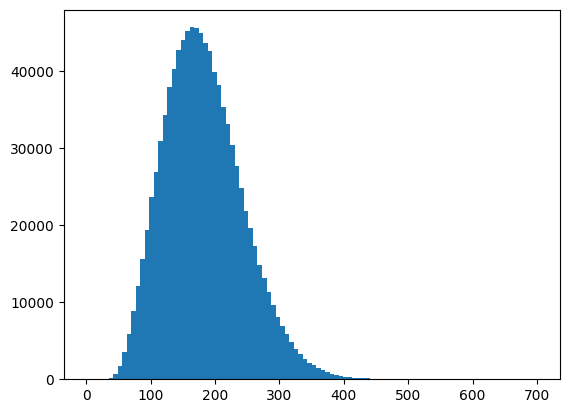

In [5]:
plt.hist(non_0, bins=100, range=(0, 700))

In [6]:
a_bkg.reshape(-1, 700, 3)[0]

array([[ 1.84024894, -2.35809541,  0.36841884],
       [ 1.31795239, -2.46422887,  0.79750216],
       [ 7.52306795, -2.42529583,  0.40591362],
       ...,
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [7]:
a_bkg = a_bkg.reshape(-1, 700, 3)

In [8]:
print(a_bkg.shape)

(1000000, 700, 3)


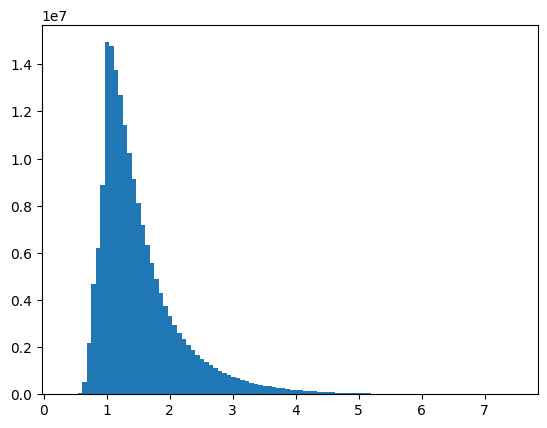

: 

In [13]:
_ = plt.hist(np.power(a_bkg[:, :, 0].flatten()[a_bkg[:, :, 0].flatten()!=0], 0.25), bins=100)
#plt.yscale("log")

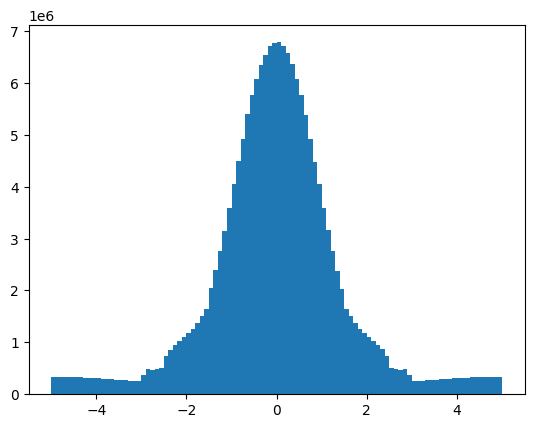

In [35]:
_ = plt.hist(a_bkg[:, :, 1].flatten()[a_bkg[:, :, 1].flatten()!=0], bins=100)

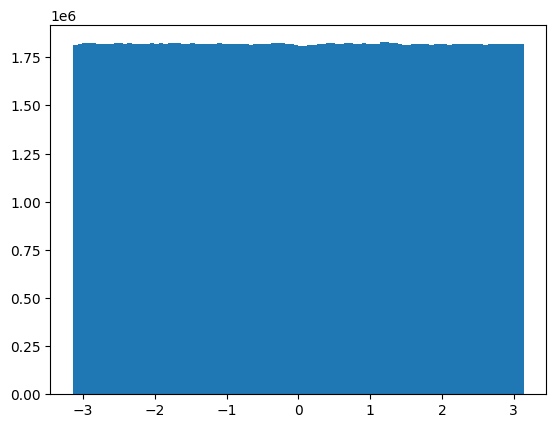

In [36]:
_ = plt.hist(a_bkg[:, :, 2].flatten()[a_bkg[:, :, 2].flatten()!=0], bins=100)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
df_hl = pd.read_hdf("/srv/beegfs/scratch/groups/rodem/LHCO/events_anomalydetection_v2.features.h5")

In [2]:
INVERTED_KEYS = [
    "pxj2",
    "pyj2",
    "pzj2",
    "mj2",
    "tau1j2",
    "tau2j2",
    "tau3j2",
    "pxj1",
    "pyj1",
    "pzj1",
    "mj1",
    "tau1j1",
    "tau2j1",
    "tau3j1",
    "label",
]

def calculate_mass(four_vector: np.ndarray) -> np.ndarray:
    """Calculate the invariant mass of a four vector."""
    return (
        np.clip(
            four_vector[:, 0] ** 2 - np.sum(four_vector[:, 1:4] ** 2, axis=1),
            0,
            None,
        )
    ) ** 0.5
def convert_lhco_to_curtain_format(df=pd.DataFrame) -> pd.DataFrame:
    """Return a new dataframe with all variables needed by the curtains project."""

    # Peform reordering such that mj1 is the smaller of the two jets
    jet_order_mask = df["mj1"] < df["mj2"]
    proper_order = df.loc[jet_order_mask]
    improper_order = df.loc[~jet_order_mask]
    improper_order.columns = INVERTED_KEYS
    df = pd.concat((proper_order, improper_order))

    data = pd.DataFrame()
    data["is_signal"] = df["label"].astype("bool")

    # Individual jet kinematics
    for jet in ["j1", "j2"]:
        data[f"px_{jet}"] = df[f"px{jet}"]
        data[f"py_{jet}"] = df[f"py{jet}"]
        data[f"pz_{jet}"] = df[f"pz{jet}"]
        data[f"m_{jet}"] = df[f"m{jet}"]

        data[f"pt_{jet}"] = np.sqrt(data[f"px_{jet}"] ** 2 + data[f"py_{jet}"] ** 2)
        data[f"phi_{jet}"] = np.arctan2(data[f"py_{jet}"], data[f"px_{jet}"])
        data[f"eta_{jet}"] = np.arcsinh(data[f"pz_{jet}"] / data[f"pt_{jet}"])
        data[f"p_{jet}"] = np.sqrt(data[f"pz_{jet}"] ** 2 + data[f"pt_{jet}"] ** 2)
        data[f"e_{jet}"] = np.sqrt(data[f"m_{jet}"] ** 2 + data[f"p_{jet}"] ** 2)

    # Combined jet mass
    data["m_jj"] = calculate_mass(
        np.sum(
            [
                data[[f"e_j{i}", f"px_j{i}", f"py_j{i}", f"pz_j{i}"]].to_numpy()
                for i in range(1, 3)
            ],
            0,
        )
    )
    return data.dropna()

In [3]:
df_cur=convert_lhco_to_curtain_format(df_hl)

In [4]:
df_cur["m_jj"]

0          3307.219387
2          3004.895272
3          3233.075105
5          2404.589107
7          2752.983540
              ...     
1099986    3527.838521
1099989    3509.159512
1099993    3409.779189
1099995    3105.457308
1099997    3546.808986
Name: m_jj, Length: 1100000, dtype: float64

In [5]:
lhco_masses = df_cur["m_jj"]
file_path = "/srv/beegfs/scratch/groups/rodem/LHCO/lhco_event_masses.h5"
with pd.HDFStore(file_path, "w") as store:
    #store.put("events", lhco_masses)
    store.put("mass", lhco_masses)